## Анализ цен на недвижимость в Москве

Для анализа возьму доступный на Kaggle датасет с данными 2024 года по ссылке: https://www.kaggle.com/datasets/ivankuznecov23/moscow-flats-prices

Данный датасет содержит подробную информацию об объектах недвижимости, включая такие параметры, как цена, площадь, количество комнат, местоположение, год постройки и тип объекта. Эти данные позволяют проводить анализ рыночных тенденций, прогнозирование цен, оценку инвестиционной привлекательности и другие исследования, связанные с рынком недвижимости.

Задачей исследования является составление портрета среднестатистической квартиры, а также какие из имеющихся в данных карактеристики квартиры наиболее сильно влияют на ее цену.

### Часть 1: подготовка и загрузка данных, первичный анализ

In [1]:
# импортирую библиотеки для работы

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sns.set(style="darkgrid")
warnings.filterwarnings('ignore')

In [2]:
# Укажу путь к файлу с данными
file_path = '/kaggle/input/prices-of-moscow-apartments/moscow_flats_dataset.csv'

# Загружу данные в датасет без последней 13 колонки, т.к. в ней ссылка на объявление, которая не важна для исследования
df = pd.read_csv(file_path, usecols=range(12))

In [3]:
# Посмотрю на датасет
df

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms
0,31633073.0,24.0,ЮАО,64.2,32.4,11.0,16.0,2023.0,1.0,0.0,3.15,2.0
1,29293000.0,9.0,СВАО,78.1,NaN,9.0,27.0,2022.0,1.0,0.0,NaN,2.0
2,30349669.0,5.0,ЮАО,72.4,33.6,3.0,24.0,2023.0,1.0,0.0,3.15,2.0
3,31845511.0,19.0,ЮАО,69.2,NaN,2.0,12.0,2024.0,1.0,0.0,2.97,2.0
4,38810000.0,27.0,ЗАО,66.9,24.8,9.0,14.0,2023.0,1.0,0.0,3.00,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6978,29504877.0,6.0,САО,86.1,49.5,3.0,12.0,NaN,0.0,0.0,NaN,4.0
6979,120000000.0,2.0,ЦАО,163.5,96.0,6.0,6.0,1998.0,0.0,0.0,3.00,4.0
6980,165000000.0,7.0,ЦАО,154.0,76.0,16.0,21.0,2023.0,0.0,0.0,NaN,4.0
6981,21500000.0,11.0,ЮВАО,94.2,69.0,2.0,5.0,NaN,0.0,0.0,2.80,4.0


In [4]:
# Выведу описательную статистику по исследуемым данным
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,6961.0,5.991086e+07,9.353880e+07,800000.0,1.650000e+07,30500000.00,63000000.00,3.737636e+09
min_to_metro,6846.0,1.318346e+01,7.716352e+01,1.0,6.000000e+00,9.00,14.00,2.025000e+03
total_area,6960.0,8.413989e+01,5.182690e+01,9.0,4.500000e+01,70.85,106.10,5.300000e+02
living_area,4514.0,4.493245e+01,3.081318e+01,1.0,2.062500e+01,37.50,60.00,3.500000e+02
floor,6960.0,1.051954e+01,1.063792e+01,-1.0,4.000000e+00,7.00,14.00,8.000000e+01
number_of_floors,6960.0,1.954138e+01,1.445648e+01,1.0,9.000000e+00,16.00,25.00,9.500000e+01
construction_year,5761.0,2.003238e+03,2.849104e+01,1820.0,1.987000e+03,2019.00,2023.00,2.027000e+03
is_new,6949.0,2.673766e-01,4.426224e-01,0.0,0.000000e+00,0.00,1.00,1.000000e+00
is_apartments,6949.0,1.565693e-01,3.634204e-01,0.0,0.000000e+00,0.00,0.00,1.000000e+00
ceiling_height,5053.0,3.035529e+00,7.147961e-01,2.0,2.700000e+00,3.00,3.15,3.000000e+01


#### Выводы: какие есть столбцы и какие отклонения есть при первом взгляде на данные  

В таблице 12 столбцов, содержащих информацию из объявлений о продаже квартир и их параметрах.

* price: цена квартиры из объявления (руб)
* min_to_metro: количество минут до ближайшего метро (мин)
* region_of_moscow: название региона Москвы
* total_area: общая площадь квартриры (м²)
* living_area: жилая площадь (м²)
* floor: этаж
* number_of_floors: всего этажей в доме
* construction_year: год постройки дома
* is_new: является ли дом новым или квартира со вторичного рынка
* is_apartments: является ли квартира апартаментами
* ceiling_height: высота потолка в метрах (м)
* number_of_rooms: количество комнат

Разброс данных показал нам, что в таблице присутствуют аномальные значения, по верхней границе (max), например максимальное значение этажа - **80**. Возможно это ошибка записи и верное значение - 8. а может продается квартира в MoscowCity. Построю также гистограммы для визуализации основных значений в первоначальном датасете.

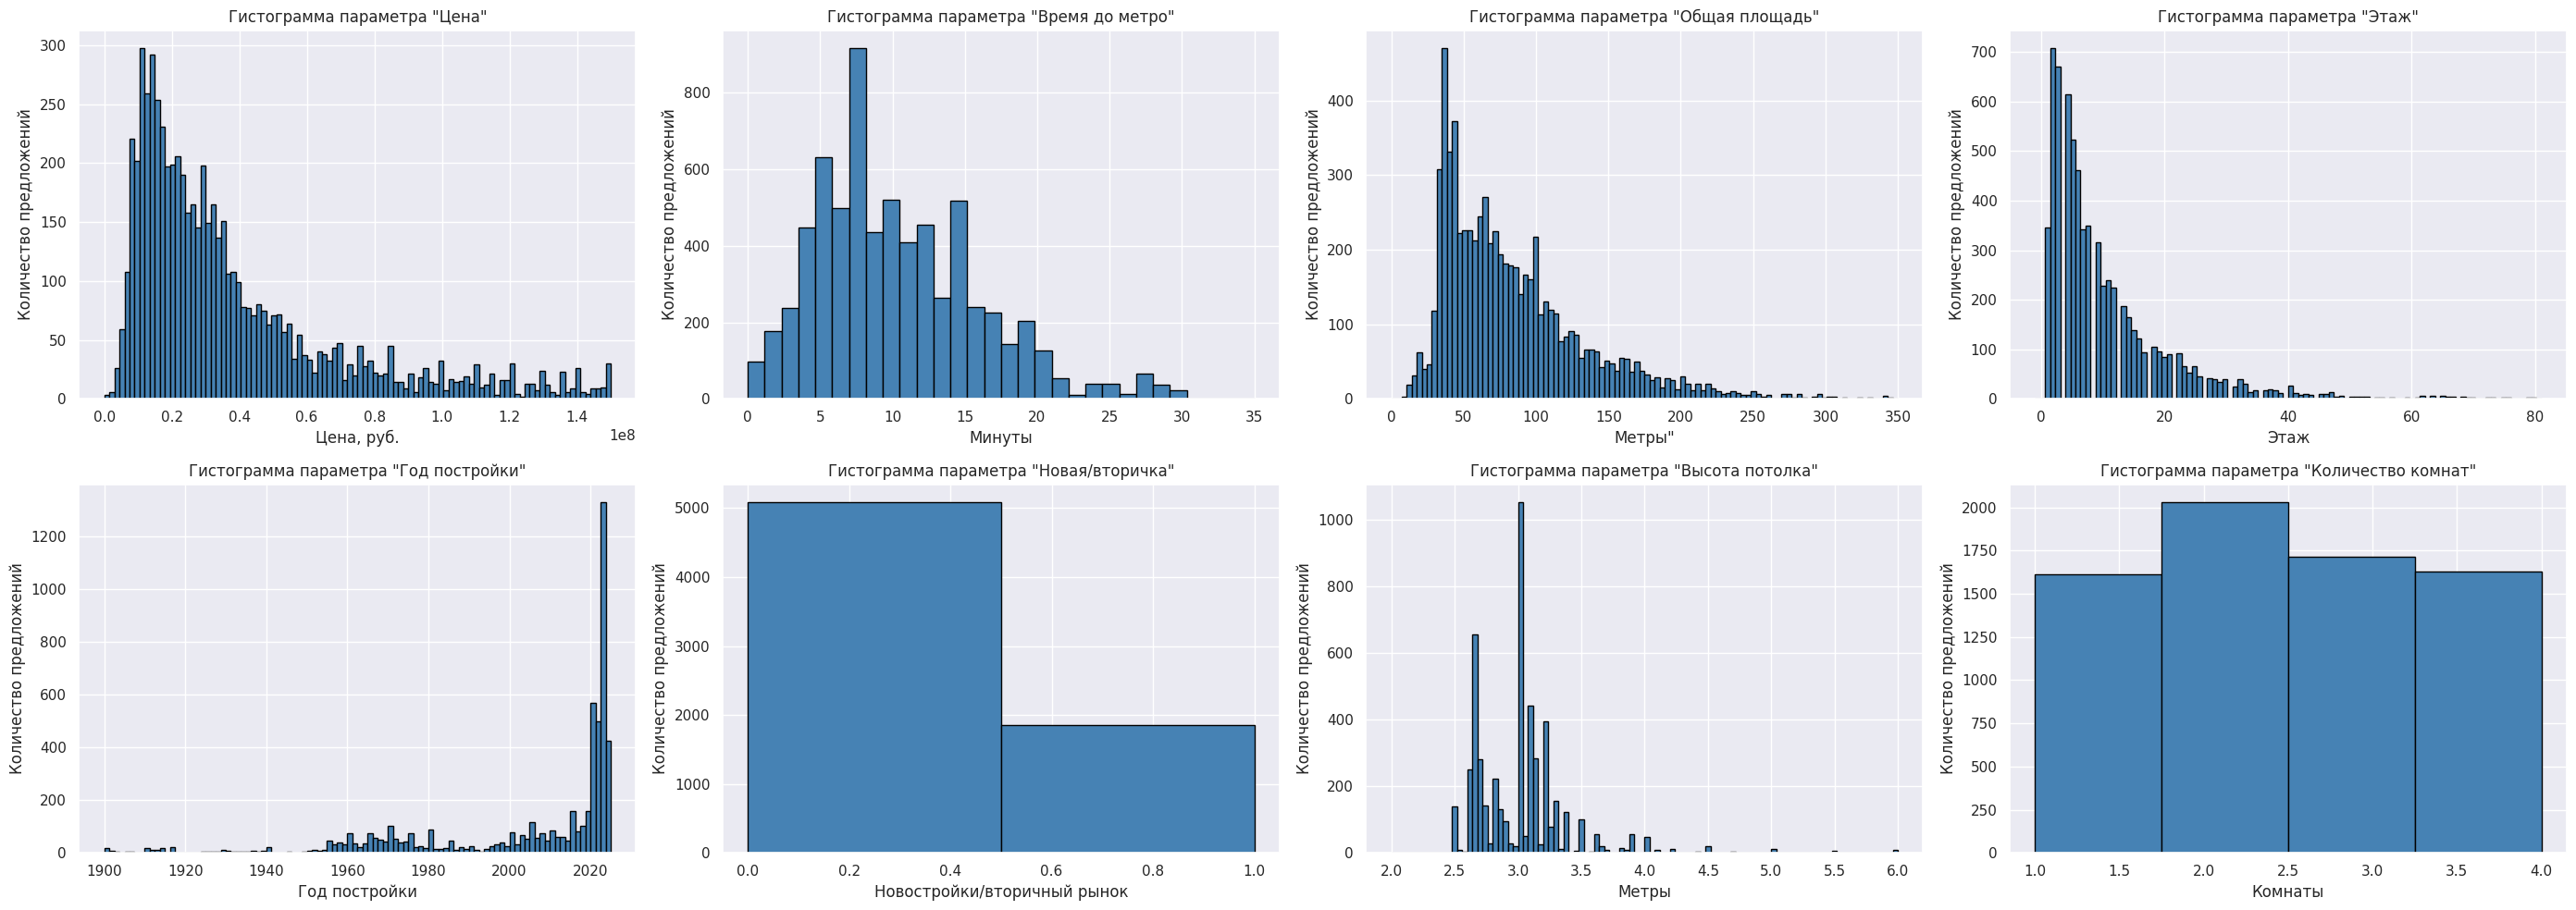

In [5]:
# Описание параметров для отображения гистограмм
hist_params = [
    {
        'column': 'price',
        'bins': 100,
        'range': (0, 150000000),
        'title': 'Гистограмма параметра "Цена"',
        'xlabel': 'Цена, руб.'
    },
    {
        'column': 'min_to_metro',
        'bins': 30,
        'range': (0, 35),
        'title': 'Гистограмма параметра "Время до метро"',
        'xlabel': 'Минуты'
    },
    {
        'column': 'total_area',
        'bins': 100,
        'range': (0, 350),
        'title': 'Гистограмма параметра "Общая площадь"',
        'xlabel': 'Метры"'
    },
    {
        'column': 'floor',
        'bins': 100,
        'range': (-1, 81),
        'title': 'Гистограмма параметра "Этаж"',
        'xlabel': 'Этаж'
    },
    {
        'column': 'construction_year',
        'bins': 100,
        'range': (1900, 2025),
        'title': 'Гистограмма параметра "Год постройки"',
        'xlabel': 'Год постройки'
    },
    {
        'column': 'is_new',
        'bins': 2,
        'range': (0, 1),
        'title': 'Гистограмма параметра "Новая/вторичка"',
        'xlabel': 'Новостройки/вторичный рынок'
    },
    {
        'column': 'ceiling_height',
        'bins': 100,
        'range': (2, 6),
        'title': 'Гистограмма параметра "Высота потолка"',
        'xlabel': 'Метры'
    },
    {
        'column': 'number_of_rooms',
        'bins': 4,
        'range': (1, 4),
        'title': 'Гистограмма параметра "Количество комнат"',
        'xlabel': 'Комнаты'
    }
]

# Создам фигуру с одной строкой и четырьмя столбцами
fig, axes = plt.subplots(2, 4, figsize=(28,10))

for idx, params in enumerate(hist_params):
    row = idx // 4
    col = idx % 4
    data = df[params['column']].dropna()
    axes[row, col].hist(data, bins=params['bins'], range=params['range'], color='steelblue', edgecolor='black')
    axes[row, col].set_title(params['title'], fontsize=12)
    axes[row, col].set_xlabel(params['xlabel'])
    axes[row, col].set_ylabel('Количество предложений')

plt.tight_layout()
plt.show()

Необходимо для достижения результатов исследования сделать следующее:
* проверить данные на наличие пропусков, дубликатов и явные аномальные значения — принять решение как их обработать, если это необходимо;
* постараться максимально сохранить исходный объем данных, но минимизировать вхождения мусорных значений в анализ.

Гистограммы выглядят, как ожидается. Большинство значений не выбивается, есть отклонения, которые были также видны при использовании describe.

### Часть 2: предобработка данных

Проверю данные на дубликаты и удалю их, если они имеются

In [6]:
# Проверяю наличие дубликатов строк в датасете
df.duplicated().sum()

47

In [7]:
# Удаляю дубликаты
df = df.drop_duplicates().reset_index(drop=True)

Проверю данные на пропуски и выведу доли их по колонкам

In [8]:
# Вывожу информацию по пропускам
df.isna().mean().sort_values(ascending=False)

living_area          0.351211
ceiling_height       0.273356
construction_year    0.171569
min_to_metro         0.017013
region_of_moscow     0.010381
is_new               0.002163
is_apartments        0.002163
total_area           0.000577
floor                0.000577
number_of_floors     0.000577
price                0.000433
number_of_rooms      0.000000
dtype: float64

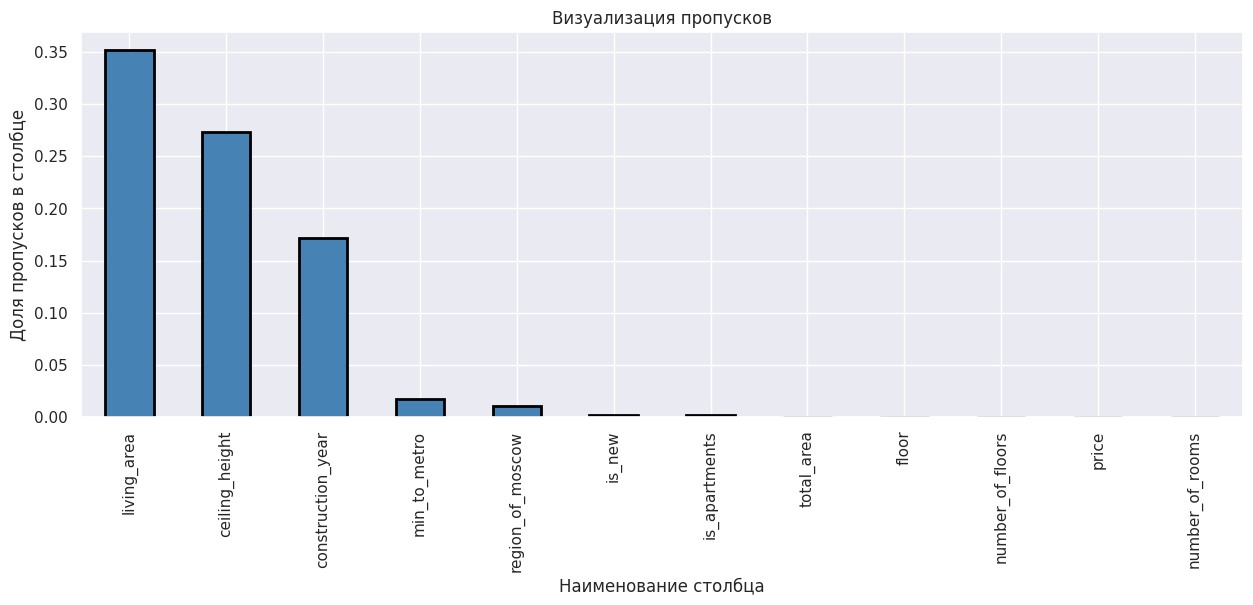

In [9]:
# Выведу информацию в виде диаграммы
df.isna().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(15,5), 
    grid=True, color='steelblue', 
    edgecolor='black', linewidth=2
)
plt.title('Визуализация пропусков')
plt.xlabel('Наименование столбца')
plt.ylabel('Доля пропусков в столбце')
plt.show()

Пропуски в основном присутствуют в трех столбцах: жилая площадь, высота потолка, год постройки. Проанализирую пять основных столбцов с пропусками для того, чтобы принять решение о том как их правильно обработать.

In [10]:
# Начну анализ с площадей: общей и жилой (самое большое количество пропусков)
print('Доля пропусков внутри столбца "total_area": {:.2%}'.format(df['total_area'].isna().sum()/len(df)))
print('Доля пропусков внутри столбца "living_area": {:.2%}'.format(df['living_area'].isna().sum()/len(df)))

Доля пропусков внутри столбца "total_area": 0.06%
Доля пропусков внутри столбца "living_area": 35.12%


In [11]:
# Проанализирую корреляцию между жилой площадью и общей
print(df['living_area'].corr(df['total_area']))

0.9020772452704787


Между жилой площадью и площадью общей есть сильная корреляция. Решаю NaN за менить на 0 и эти данные исключать при выборке (используя строгие неравенства). Какие есть варианты обработки пропусков?
* Удалять строки с пропусками по жилой площади не выход, т.к. потеряю большое количество данных по иным строкам.
* Замена на 0 — обычно применяют для признаков, где 0 — корректное значение (например, количество балконов), но квартира не может иметь жилую площадь 0 м²
* Заполнение средним, медианой или регрессионная импутация — замена NaN на среднее/медиану по группе (например, по типу жилья, району или по связи со столбцом 'total_area'). При высокой корреляции логичнее всего заполнить пропуски 'living_area' при помощи регрессионной оценки по 'total_area' (например, построить линейную модель и подставить значения).

Логично выбрать последний вариант.

In [12]:
# Проверяю столбец с высотой потолка
print('Доля пропусков внутри столбца "ceiling_height": {:.2%}'.format(df['ceiling_height'].isna().sum()/len(df)))

Доля пропусков внутри столбца "ceiling_height": 27.34%


Методом describe() ранее показал, что в данном столбце находятся артефакты - есть потолки как 2.00 метра, так и 30. Найду разброс между средним и медианным значением.

In [13]:
# Вывожу среднее и медианное значение
print(df['ceiling_height'].mean())
print(df['ceiling_height'].median())

3.0355059523809524
3.0


Согласно п.5.12 СП 54.13330.2022 «СНИП 31-01-2003 Здания жилые многоквартирные»:
"Высота (от пола до потолка) жилых комнат и кухни (кухни-столовой) в климатических подрайонах строительства IA, IБ, IГ, IД и IVА, определяемых по СП 131.13330, должна быть не менее 2,7 м, а в других климатических подрайонах строительства – не менее 2,5 м."
Что мы видим: средняя и медиана превышают рамки СНиП.

Как можно поступить в этом случае?
* Удалить/заменить очевидные выбивающиеся значения (например, высоты потолков 30 м) — это явные ошибки ввода. Корректно оставить значения в диапазоне примерно 2,4–4 метров.
* Заполнить пропуски медианой — это стандартная техника для количественных признаков с выбросами, более устойчивая, чем среднее. В случае высоты потолков медиана — обычно близка к типовой планировке для региона (3,0).
* Воспользоваться нормативом как минимальным значением — если важно соответствие стандарту, то пропуски можно заменять значением 2,7 м. Логично для массовых построек и статистических моделей для Москвы.

Таким образом, экстремально низкие и высокие значения заменяю нормативом, как и пропуски.

In [14]:
# Проверяю столбец с годом постройки дома
print('Доля пропусков внутри столбца "construction_year": {:.2%}'.format(df['construction_year'].isna().sum()/len(df)))

Доля пропусков внутри столбца "construction_year": 17.16%


Для случая пропусков с годом постройки, заполню медианой по группам домов. В датасете есть признаки, связанные с годом постройки (район, количество этажей, новый дом или нет, апартаменты или нет). Заменияю пропуски на медиану по этим группам. Например, старый район — одна медиана, новостройки — другая. Можно также скомбинировать эти признаки и высчитать среднюю медиану по этим категориям.

In [15]:
# Проверяю столбец с расстоянием до ближайшего метро
print('Доля пропусков внутри столбца "min_to_metro": {:.2%}'.format(df['min_to_metro'].isna().sum()/len(df)))

Доля пропусков внутри столбца "min_to_metro": 1.70%


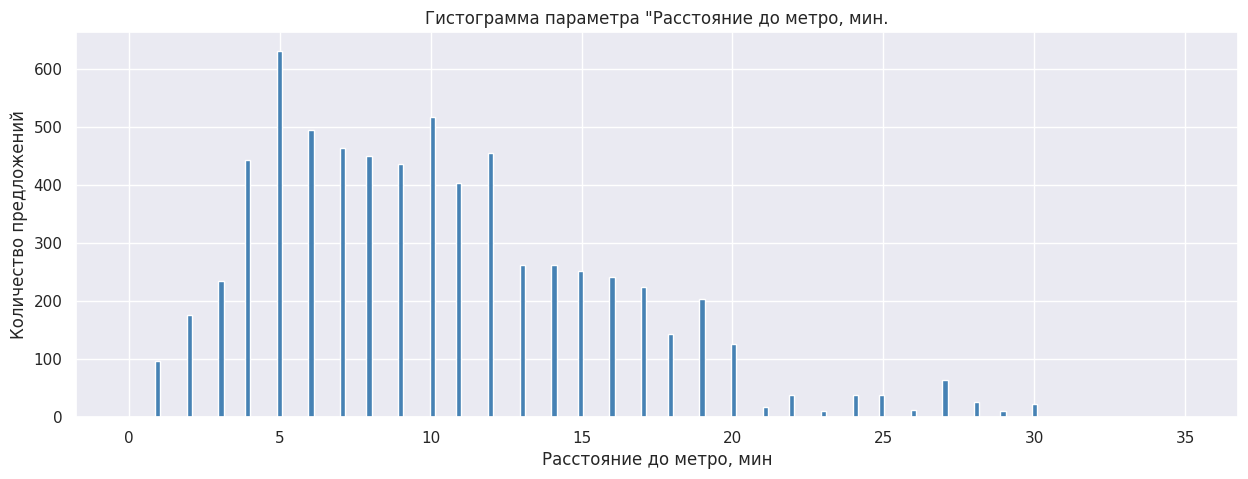

In [16]:
# В данном случае взгляну на данные в более близком приближении
df['min_to_metro'].hist(bins=200, range= (0, 35), color='steelblue', figsize=(15, 5))
plt.title('Гистограмма параметра "Расстояние до метро, мин.')
plt.xlabel('Расстояние до метро, мин')
plt.ylabel('Количество предложений')
plt.show()

В случае со столбцом "min_to_metro", где пропусков всего 1.7%, заменять NaN на 0 или исключать при анализе — не лучший вариант. Такой подход приводит к логической ошибке: 0 означает, что квартира находится непосредственно у метро, тогда как пропуск подразумевает отсутствие информации о расстоянии. Какие есть лучшие практики, что выбрать?

* Медиана/мода: если в районе большинство квартир имеют схожее расстояние до метро, можно заполнить пропуски медианой или модой внутри этого района;

* Удаление строк: при очень малом числе пропусков (как в данном случае) не критично удалить эти строки, если они не важны для объема анализа;

* Специальное значение: можно подставить уникальное значение (например, -1) и добавить столбец "min_to_metro_missing", это подход для ML-моделей.

В данном случае выберу медиану (т.к. менее подвержена выбросам) в предалах района.


In [17]:
# Проверяю столбец с регионом Москвы
print('Доля пропусков внутри столбца "region_of_moscow": {:.2%}'.format(df['region_of_moscow'].isna().sum()/len(df)))

Доля пропусков внутри столбца "region_of_moscow": 1.04%


В данном случае, с пропусками по региону города, подойдет замена специальным маркером: обычно NaN в категориальном поле заменяют строкой "unknown", "no_region", "not_specified" или аналогичным значением. Это исключает потерю данных и позволяет вам анализировать или фильтровать такие строки отдельно.

Остались колонки с долей пропусков менее 1%.

Это такие колонки:<br>
is_new<br>
is_apartments<br>
total_area<br>
floor<br>
number_of_floors<br>
price

* Главный интересующий нас признак по исследованию: цена (price), если в объявлении не указана цена, то оно нас в принципе не интересует. В данном случае удалю эти строки полностью;
* Числовые признаки (total_area, floor, number_of_floors): оптимальной и быстрой практикой считается заполнение пропусков медианой столбца. При таком малом количестве пропусков влияние на статистику будет минимальное;
* Бинарные признаки (is_new, is_apartments): для бинарных столбцов (0/1) пропуски обычно заполняют самым частым значением (мода), либо, если контекст позволяет, значение 0 — как стандартное отсутствие признака. В данном случае выберу моду.

#### Обработка пропусков

Создам новый датасет и начну заполнять пропуски и удалять лишние значения, согласно плана выше. Начну с конца.

In [18]:
# Создам резервную копию исходного датафрейма
df_backup = df.copy()

# Буду работать с копией
df_cleaned = df_backup.copy()

In [19]:
# Удалю строки, где price == NaN
df_cleaned = df_cleaned.dropna(subset=['price']).reset_index(drop=True)

# Проверка результата
print(f'Первичный размер датафрейма: {df.shape}')
print(f'Новый размер датафрейма: {df_cleaned.shape}')
print(f'Количество пропусков в price: {df_cleaned["price"].isna().sum()}')

Первичный размер датафрейма: (6936, 12)
Новый размер датафрейма: (6933, 12)
Количество пропусков в price: 0


In [20]:
# Заполняю медианой столбцы: total_area, floor, number_of_floors
for col in ['total_area', 'floor', 'number_of_floors']:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)

# Проверка
print(df_cleaned[['total_area', 'floor', 'number_of_floors']].isna().sum())

total_area          0
floor               0
number_of_floors    0
dtype: int64


In [21]:
# Заполняю модой столбцы: is_new, is_apartments
for col in ['is_new', 'is_apartments']:
    mode_val = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(mode_val)

# Проверка
print(df_cleaned[['is_new', 'is_apartments']].isna().sum())

is_new           0
is_apartments    0
dtype: int64


In [22]:
# Заполняю значением 'unknown' столбцец region_of_moscow
df_cleaned['region_of_moscow'] = df_cleaned['region_of_moscow'].fillna('unknown')

# Проверка
print(df_cleaned['region_of_moscow'].isna().sum())
print(df_cleaned['region_of_moscow'].value_counts())

0
region_of_moscow
ЦАО        1644
ЗАО        1259
СЗАО        724
ЮАО         696
САО         654
СВАО        543
ЮВАО        501
ЮЗАО        467
ВАО         376
unknown      69
Name: count, dtype: int64


In [23]:
# Заполняю значением моды по региону Москвы пропуски в столбце min_to_metro
df_cleaned['min_to_metro'] = df_cleaned.groupby('region_of_moscow')['min_to_metro'].transform(
    lambda x: x.fillna(x.median())
)

# Проверка
print(df_cleaned['min_to_metro'].isna().sum())

0


In [24]:
# Заполняю значением медианы пропуски в столбце construction_year
# Первый проход — медиана по группам полей: 'region_of_moscow', 'number_of_floors', 'is_new', 'is_apartments'
group_cols = ['region_of_moscow', 'number_of_floors', 'is_new', 'is_apartments']
df_cleaned['construction_year'] = df_cleaned.groupby(group_cols)['construction_year'].transform(
    lambda x: x.fillna(x.median())
)

# Второй проход — медиана по всему датасету (заполняет остаточные NaN, после первого прохода)
df_cleaned['construction_year'] = df_cleaned['construction_year'].fillna(df_cleaned['construction_year'].median())

# Проверка
print(df_cleaned['construction_year'].isna().sum())

0


In [25]:
# Все значения ceiling_height вне диапазона 2.4–4 заменяю на 2.7
df_cleaned.loc[(df_cleaned['ceiling_height'] < 2.4) | (df_cleaned['ceiling_height'] > 4), 'ceiling_height'] = 2.7

# Пропуски также заполняю значением 2.7
df_cleaned['ceiling_height'] = df_cleaned['ceiling_height'].fillna(2.7)

# Проверка
print(df_cleaned['ceiling_height'].isna().sum())

0


In [26]:
# 1. Заполняю пропуски в total_area медианой
df_cleaned['total_area'] = df_cleaned['total_area'].fillna(df_cleaned['total_area'].median())

# Проверка
print(df_cleaned['total_area'].isna().sum())

# 2. Сделаю импутацию пропусков living_area через линейную регрессию по total_area

# Отберу строки без пропусков для обучения регрессии
mask = df_cleaned['living_area'].notna() & df_cleaned['total_area'].notna()
X = df_cleaned.loc[mask, ['total_area']]
y = df_cleaned.loc[mask, 'living_area']

model = LinearRegression()
model.fit(X, y)

# Найду строки, где есть пропуски в living_area и заполню их предсказаниями регрессии
nan_mask = df_cleaned['living_area'].isna() & df_cleaned['total_area'].notna()
X_pred = df_cleaned.loc[nan_mask, ['total_area']]
df_cleaned.loc[nan_mask, 'living_area'] = model.predict(X_pred)

# Проверка
print(df_cleaned['living_area'].isna().sum())

0
0


In [27]:
# Еще раз выведу описательную статистику по обработанным данным
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
price,6933.0,5.956379e+07,9.328556e+07,800000.00,16500000.0,30439054.00,62000000.0,3.737636e+09
min_to_metro,6933.0,1.314135e+01,7.667844e+01,1.00,6.0,9.00,14.0,2.025000e+03
total_area,6933.0,8.396328e+01,5.174371e+01,9.00,45.0,70.60,105.8,5.300000e+02
living_area,6933.0,4.821792e+01,3.220590e+01,1.00,24.4,40.00,63.6,3.500000e+02
floor,6933.0,1.052012e+01,1.061460e+01,-1.00,4.0,7.00,14.0,8.000000e+01
number_of_floors,6933.0,1.955373e+01,1.444327e+01,1.00,9.0,16.00,25.0,9.500000e+01
construction_year,6933.0,2.002925e+03,2.768023e+01,1820.00,1989.0,2017.00,2023.0,2.027000e+03
is_new,6933.0,2.679937e-01,4.429462e-01,0.00,0.0,0.00,1.0,1.000000e+00
is_apartments,6933.0,1.562094e-01,3.630800e-01,0.00,0.0,0.00,0.0,1.000000e+00
ceiling_height,6933.0,2.900387e+00,2.834298e-01,2.48,2.7,2.75,3.1,4.000000e+00


In [28]:
# Посмотрю на данные после обработки
df_cleaned.head(5)

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms
0,31633073.0,24.0,ЮАО,64.2,32.400000,11.0,16.0,2023.0,1.0,0.0,3.15,2.0
1,29293000.0,9.0,СВАО,78.1,44.776092,9.0,27.0,2022.0,1.0,0.0,2.70,2.0
2,30349669.0,5.0,ЮАО,72.4,33.600000,3.0,24.0,2023.0,1.0,0.0,3.15,2.0
3,31845511.0,19.0,ЮАО,69.2,39.551675,2.0,12.0,2024.0,1.0,0.0,2.97,2.0
4,38810000.0,27.0,ЗАО,66.9,24.800000,9.0,14.0,2023.0,1.0,0.0,3.00,2.0


В данных есть значительное количество выбросов по верхней границе:
| Переменная         | Максимальное значение      |
|--------------------|---------------------------|
| price              | 3 737 636 000 рублей      |
| min_to_metro       | 2 025 минут               |
| total_area         | 530 м²                    |
| living_area        | 350 м²                    |
| floor              | 100                       |
| number_of_floors   | 100                       |
| construction_year  | 2 027                     |
| is_new             | 1 (истина/да)             |
| is_apartments      | 1 (истина/да)             |
| ceiling_height     | 4.0 метра                 |
| number_of_rooms    | 4                         |

#### Замена типов значений

В обработанном датасете есть такие колонки, которые для удобства переведу в следующие типы данных, сгруппирую по типу замены значения.

##### Перевод к целочисленному значению с отбросом знаков после запятой (без округления):
* floor — полуэтажа быть не может, переведу к целочисленному значению;
* number_of_floors — аналогично предыдущему пункту;
* construction_year — требуется перевод к целочисленному значению, обозначающему год постройки;
* is_new — булево значение, переведу к целочисленному типу;
* is_apartments — аналогично предыдущему пункту;
* number_of_rooms — приведу к целочисленному (комнаты должны быть целыми, доли не считаю).
  
##### Стандартное математическое округление
* price — приведу к целочисленному значению, для исключения подсчета копеек в цене;
* min_to_metro — также приведу к целочисленному, поскольку похоже в данных отсутствуют дробные значения;
* ceiling_height — округлю до 1 знака после запятой, тип float (высота потолков согласно СНИП принята до 1 знака после запятой);
* living_area — округлю до 1 знака после запятой, тип float (площадь принято считать до 1 знака).

##### Оставлю как есть
* region_of_moscow — в замене не нуждается;
* total_area — не нуждается в замене: площадь принято считать до 1 знака после запятой.

In [29]:
# Перевожу к целым числам
df_cleaned['floor'] = df_cleaned['floor'].astype(int)
df_cleaned['number_of_floors'] = df_cleaned['number_of_floors'].astype(int)
df_cleaned['construction_year'] = df_cleaned['construction_year'].astype(int)
df_cleaned['is_new'] = df_cleaned['is_new'].astype(int)
df_cleaned['is_apartments'] = df_cleaned['is_apartments'].astype(int)
df_cleaned['number_of_rooms'] = df_cleaned['number_of_rooms'].astype(int)

# Стандартное математическое округление
df_cleaned['price'] = df_cleaned['price'].round().astype(int)
df_cleaned['min_to_metro'] = df_cleaned['min_to_metro'].round().astype(int)
df_cleaned['ceiling_height'] = df_cleaned['ceiling_height'].round(1).astype(float)
df_cleaned['living_area'] = df_cleaned['living_area'].round(1).astype(float)

In [30]:
# Посмотрю на данные после полной обработки
df_cleaned.head(5)

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms
0,31633073,24,ЮАО,64.2,32.4,11,16,2023,1,0,3.2,2
1,29293000,9,СВАО,78.1,44.8,9,27,2022,1,0,2.7,2
2,30349669,5,ЮАО,72.4,33.6,3,24,2023,1,0,3.2,2
3,31845511,19,ЮАО,69.2,39.6,2,12,2024,1,0,3.0,2
4,38810000,27,ЗАО,66.9,24.8,9,14,2023,1,0,3.0,2


Очистка и обработка завершены.

### Часть 3: обогащение данных

Можно на основе имеющихся столбцов рассчитать дополнительные, для того чтобы улучшить качество анализа данных. Есть такие опции для обогащения:
* Цена за квадратный метр, целочисленное значение;
* Этаж квартиры. Категорирование: выделю следующие категории — подвал, первый этаж, последний этаж, прочие этажи. Категориальная переменная;
* Соотношение жилой и общей площади, float — один знак после запятой.

In [31]:
# Добавлю цену за квадратный метр (целое число)
df_cleaned['price_per_m2'] = (df_cleaned['price'] / df_cleaned['total_area']).round().astype(int)

# Добавлю категориальную переменную: тип этажа
def floor_category(row):
    if row['floor'] < 0:
        return 'подвал'
    elif row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['number_of_floors']:
        return 'последний'
    else:
        return 'прочие'
df_cleaned['floor_category'] = df_cleaned.apply(floor_category, axis=1)

# Добавлю соотношение жилой площади к общей (до 1 знака после запятой)
df_cleaned['living_ratio'] = (df_cleaned['living_area'] / df_cleaned['total_area']).round(1)

In [32]:
# Посмотрю на финальную версию данных после обогащения и обработки
df_cleaned.head(5)

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,price_per_m2,floor_category,living_ratio
0,31633073,24,ЮАО,64.2,32.4,11,16,2023,1,0,3.2,2,492727,прочие,0.5
1,29293000,9,СВАО,78.1,44.8,9,27,2022,1,0,2.7,2,375070,прочие,0.6
2,30349669,5,ЮАО,72.4,33.6,3,24,2023,1,0,3.2,2,419194,прочие,0.5
3,31845511,19,ЮАО,69.2,39.6,2,12,2024,1,0,3.0,2,460195,прочие,0.6
4,38810000,27,ЗАО,66.9,24.8,9,14,2023,1,0,3.0,2,580120,прочие,0.4


Датасет полностью готов к анализу.

### Часть 4: исследовательский анализ данных

Изучу основные категории и построю по ним боксплоты. Это будут:
* цена;
* общая площадь;
* количество комнат;
* расстояние до метро;
* высота потолка

Медиана цены:  30439054.0
Медиана общей площади:  70.6
Медиана количества комнат:  2.0
Медиана расстояния до метро:  9.0
Медиана высота потолков:  2.8


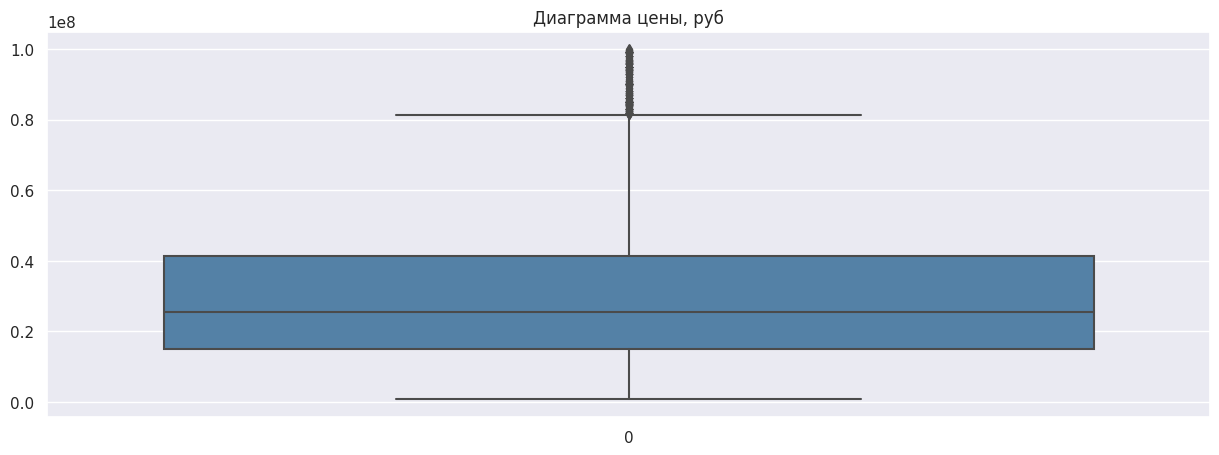

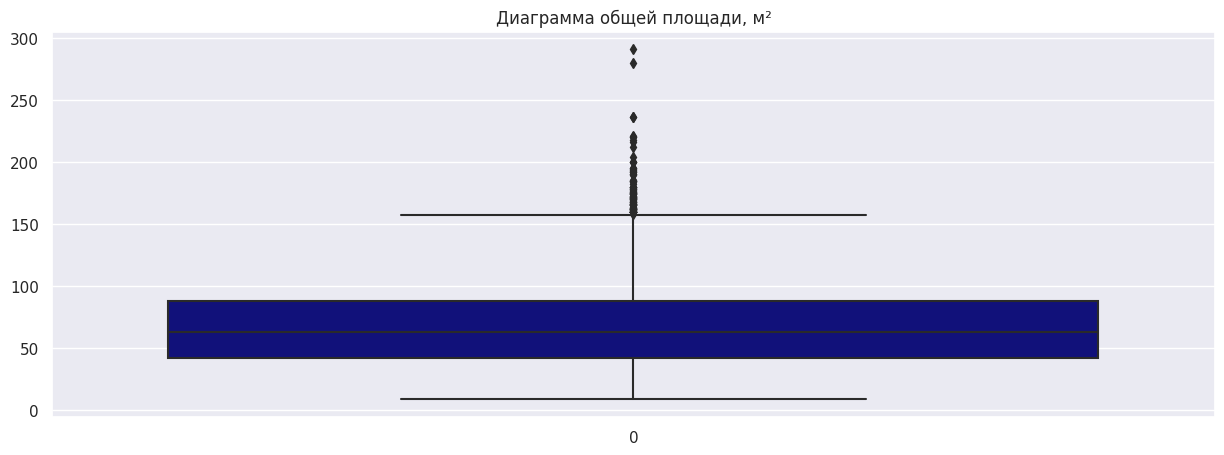

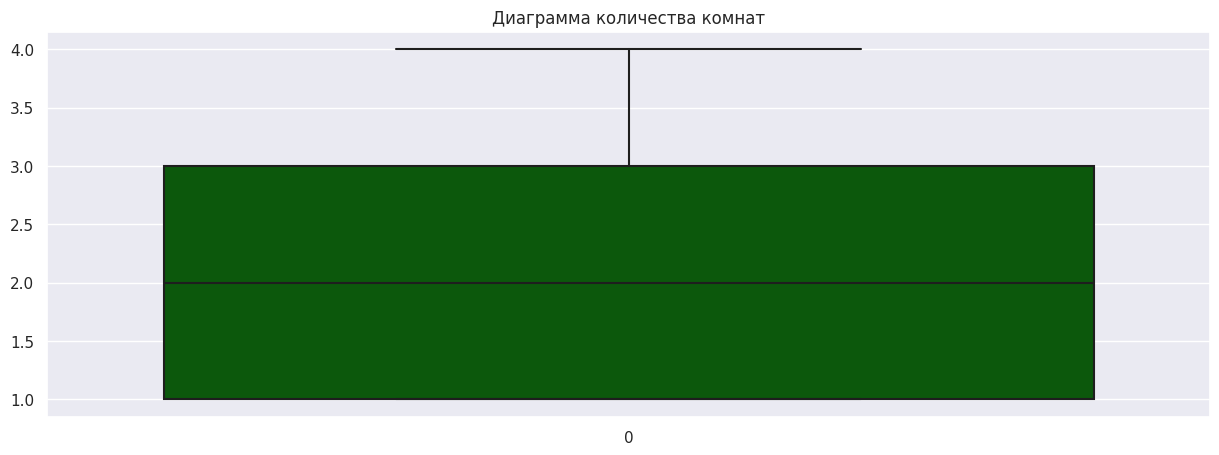

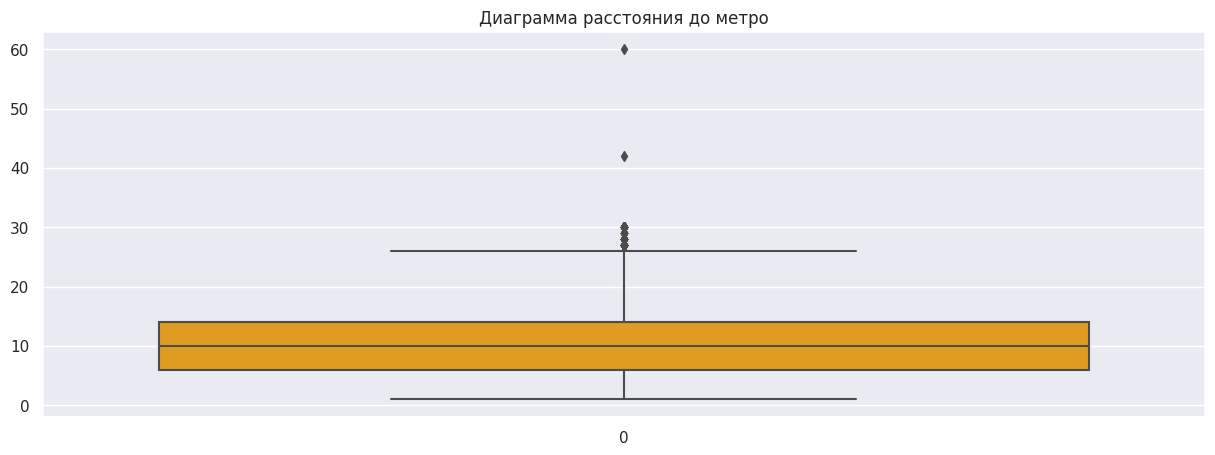

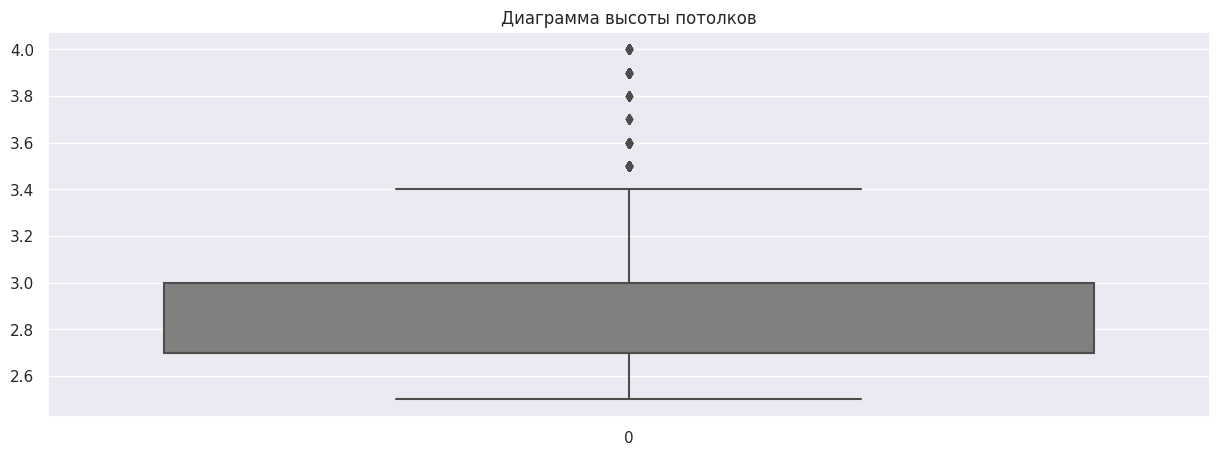

In [33]:
print('Медиана цены: ', df_cleaned['price'].median())
print('Медиана общей площади: ', df_cleaned['total_area'].median())
print('Медиана количества комнат: ', df_cleaned['number_of_rooms'].median())
print('Медиана расстояния до метро: ', df_cleaned['min_to_metro'].median())
print('Медиана высота потолков: ', df_cleaned['ceiling_height'].median())

# Сделаю промежуточный датасет без выбросов для визуализации
df_cleaned_visual = df_cleaned[
    (df_cleaned['min_to_metro'] < 200) &   # Расстояние до метро < 200 минут
    (df_cleaned['price'] < 100000000) &    # Цена < 100 млн
    (df_cleaned['total_area'] < 500)       # Площадь < 500 м²
].copy()

# Создам списки параметров
columns_list = ['price', 'total_area', 'number_of_rooms', 'min_to_metro', 'ceiling_height']
title_list = ['Диаграмма цены, руб', 'Диаграмма общей площади, м²', 
              'Диаграмма количества комнат', 'Диаграмма расстояния до метро', 'Диаграмма высоты потолков']
color_list=['steelblue', 'darkblue', 'darkgreen', 'orange', 'gray']
# Задам цикл построения графиков с параметрами
for i in range(len(columns_list)):
    plt.figure(figsize=(15, 5))
    sns.boxplot(df_cleaned_visual[columns_list[i]], color=color_list[i])
    plt.title(title_list[i])
    plt.xlabel('')
    plt.show()

**Среднестатистическая квартира получилась следующая**: 
* стоимостью 30 млн. рублей;
* площадью 70 квадратных метра;
* 2-х комнатная;
* расстояние до метро 9 мин.;
* высота потолков 2.6 м.

Взгляну также на гистограммы ключевых показателей.

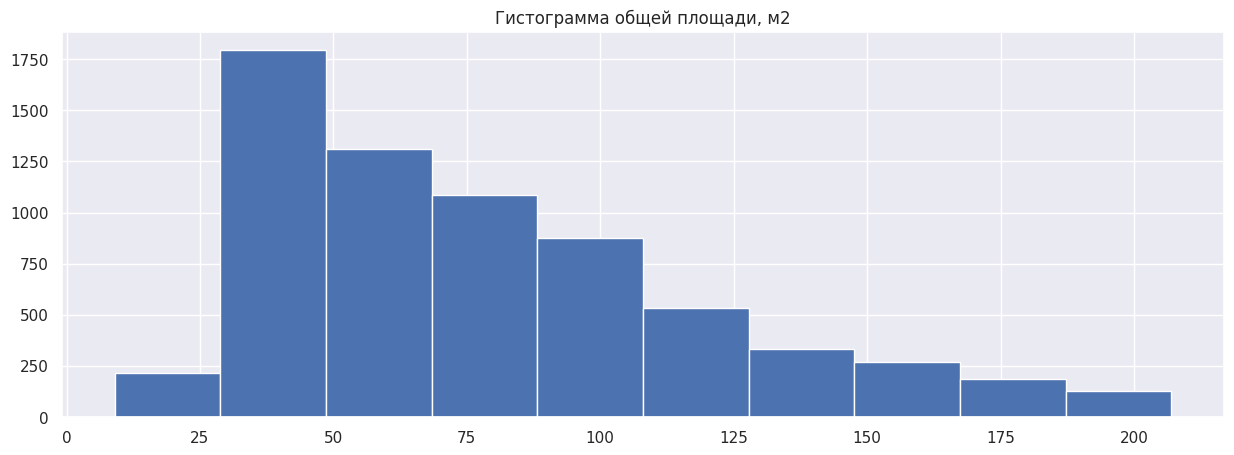

In [34]:
# Строю гистограмму общей площади
df_cleaned['total_area'].hist(range=df_cleaned['total_area'].quantile([.0,.97])
                               , figsize=(15,5))
plt.title('Гистограмма общей площади, м2')
plt.show()

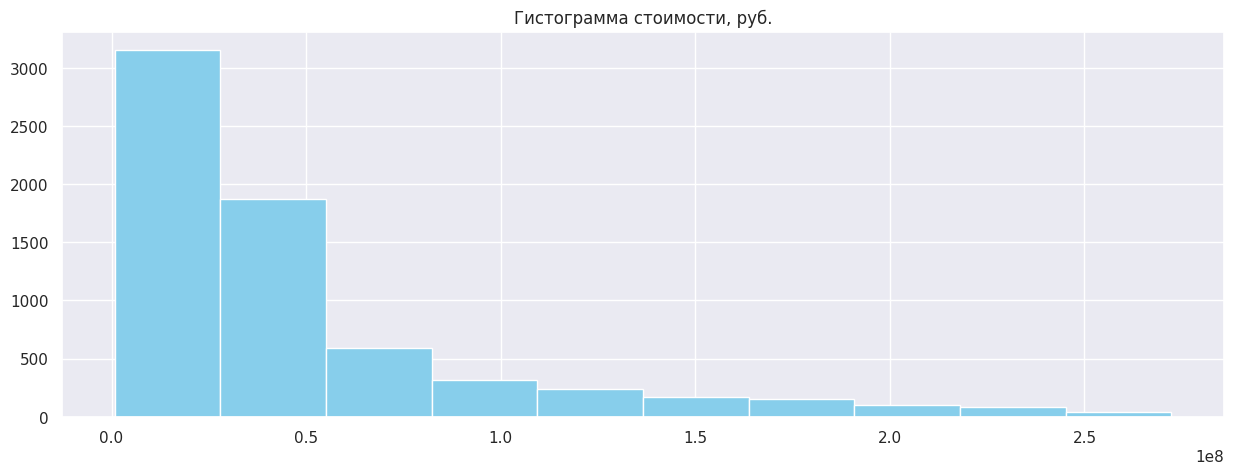

In [35]:
# Строю гистограмму цены
df_cleaned['price'].hist(range=df_cleaned['price'].quantile([.0,.97]), 
                                    figsize=(15,5),
                                    color='skyblue')
plt.title('Гистограмма стоимости, руб.')
plt.show()

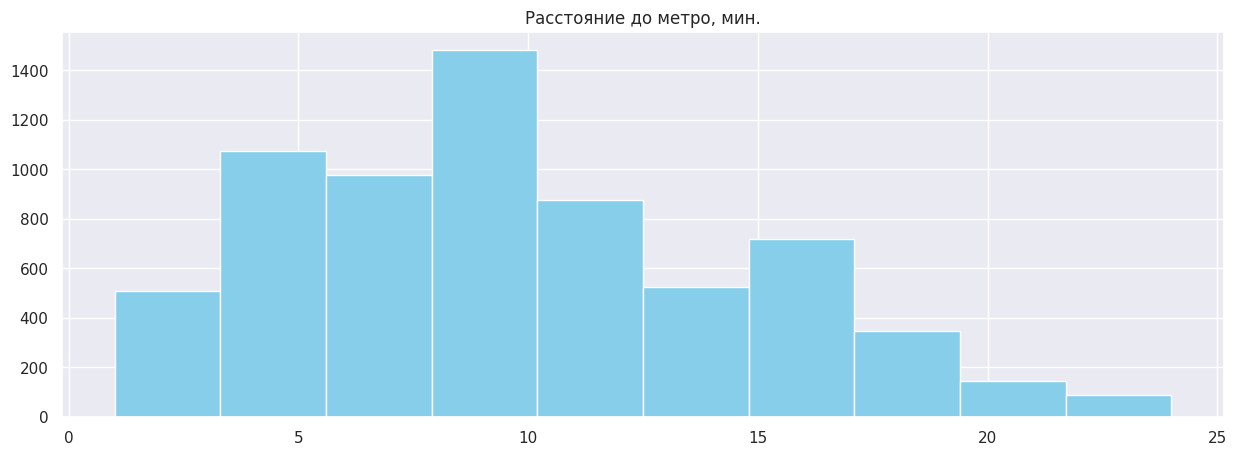

In [36]:
# Строю гистограмму расстояний до метро
df_cleaned['min_to_metro'].hist(range=df_cleaned['min_to_metro'].quantile([.0,.97]), 
                                    figsize=(15,5),
                                    color='skyblue')
plt.title('Расстояние до метро, мин.')
plt.show()

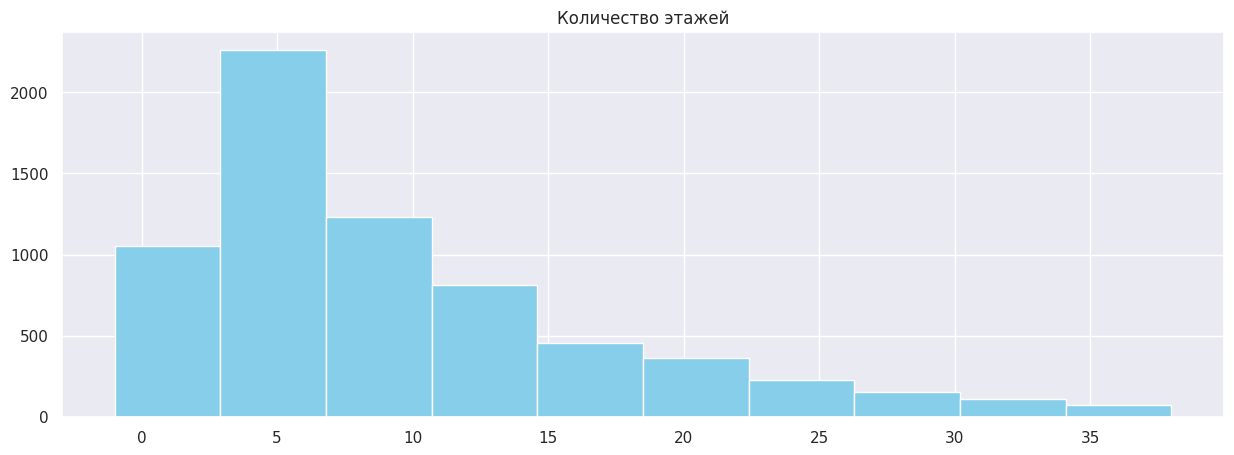

In [37]:
# Строю гистограмму количества этажей
df_cleaned['floor'].hist(range=df_cleaned['floor'].quantile([.0,.97]), 
                                    figsize=(15,5),
                                    color='skyblue')
plt.title('Количество этажей')
plt.show()

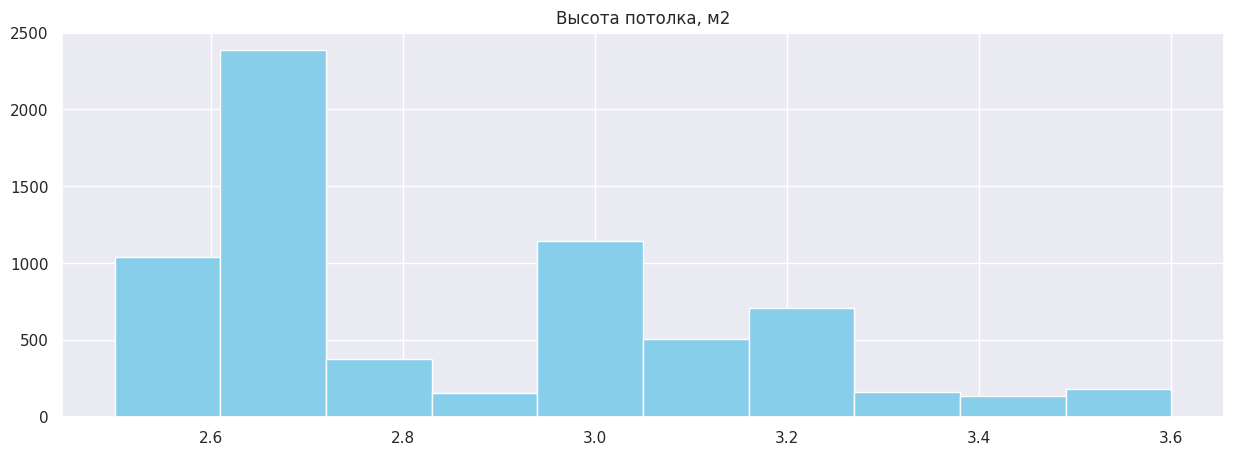

In [38]:
# Строю гистограмму количества этажей
df_cleaned['ceiling_height'].hist(range=df_cleaned['ceiling_height'].quantile([.0,.97]), 
                                    figsize=(15,5),
                                    color='skyblue')
plt.title('Высота потолка, м2')
plt.show()

Сделаю срез из обработанной таблицы для получения датасета со значениями в рамках диапазонов размаха по значениям, чтобы экстремальные значения не влияли на итоговые выводы.

Для ответа на окончательные вопросы давайте соберем отфильтрованные данные. По этим столбцам будем брать следующие параметры:
* цена до 500 000 рублей;
* расстояние до метро: до 60 минут;
* количество этажей: до 50

In [39]:
# Делаю итоговый датасет для формирования выводов
final_df = df_cleaned [(df_cleaned['price'] <=500_000_000) & \
                      (df_cleaned['min_to_metro'] <=50) & \
                      (df_cleaned['floor'] <=50)]

In [40]:
# Посчитаю долю получившейся финальной выборки от начальной
print('Выборка для анализа составляет: {:.2%}'.format(len(final_df)/len(df_cleaned)))

Выборка для анализа составляет: 98.23%


In [41]:
# Посчитаю корреляцию между признаками
final_df_group = final_df[['price', 'min_to_metro', 
                           'total_area', 'living_area',
                           'floor', 'number_of_floors',
                           'construction_year', 'is_new',
                           'is_apartments', 'ceiling_height',
                           'number_of_rooms', 'price_per_m2',
                           'living_ratio']]
final_df_group.corr()

,price,min_to_metro,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,price_per_m2,living_ratio
price,1.000000,-0.126761,0.792270,0.743260,-0.018082,-0.085202,0.088658,-0.071750,0.035006,0.293371,0.448851,0.878396,0.090632
min_to_metro,-0.126761,1.000000,-0.101532,-0.132820,0.046789,0.018635,0.154841,0.213554,-0.108523,-0.049639,-0.096573,-0.131710,-0.173645
total_area,0.792270,-0.101532,1.000000,0.944491,0.072339,0.020093,0.098672,-0.038391,-0.034271,0.304449,0.740743,0.526069,0.158023
living_area,0.743260,-0.132820,0.944491,1.000000,0.038474,-0.002458,0.020357,-0.104638,-0.032115,0.278393,0.759058,0.486866,0.408775
floor,-0.018082,0.046789,0.072339,0.038474,1.000000,0.689663,0.349513,0.239534,-0.034566,0.073487,0.033897,-0.024782,-0.126215
number_of_floors,-0.085202,0.018635,0.020093,-0.002458,0.689663,1.000000,0.463760,0.242028,-0.021558,0.076032,-0.002789,-0.063411,-0.097435
construction_year,0.088658,0.154841,0.098672,0.020357,0.349513,0.463760,1.000000,0.433660,0.093361,0.118406,-0.013926,0.134413,-0.255237
is_new,-0.071750,0.213554,-0.038391,-0.104638,0.239534,0.242028,0.433660,1.000000,-0.020370,0.119425,-0.080420,-0.048500,-0.247170
is_apartments,0.035006,-0.108523,-0.034271,-0.032115,-0.034566,-0.021558,0.093361,-0.020370,1.000000,0.162161,-0.123814,0.085139,0.016796
ceiling_height,0.293371,-0.049639,0.304449,0.278393,0.073487,0.076032,0.118406,0.119425,0.162161,1.000000,0.213457,0.324153,0.014819


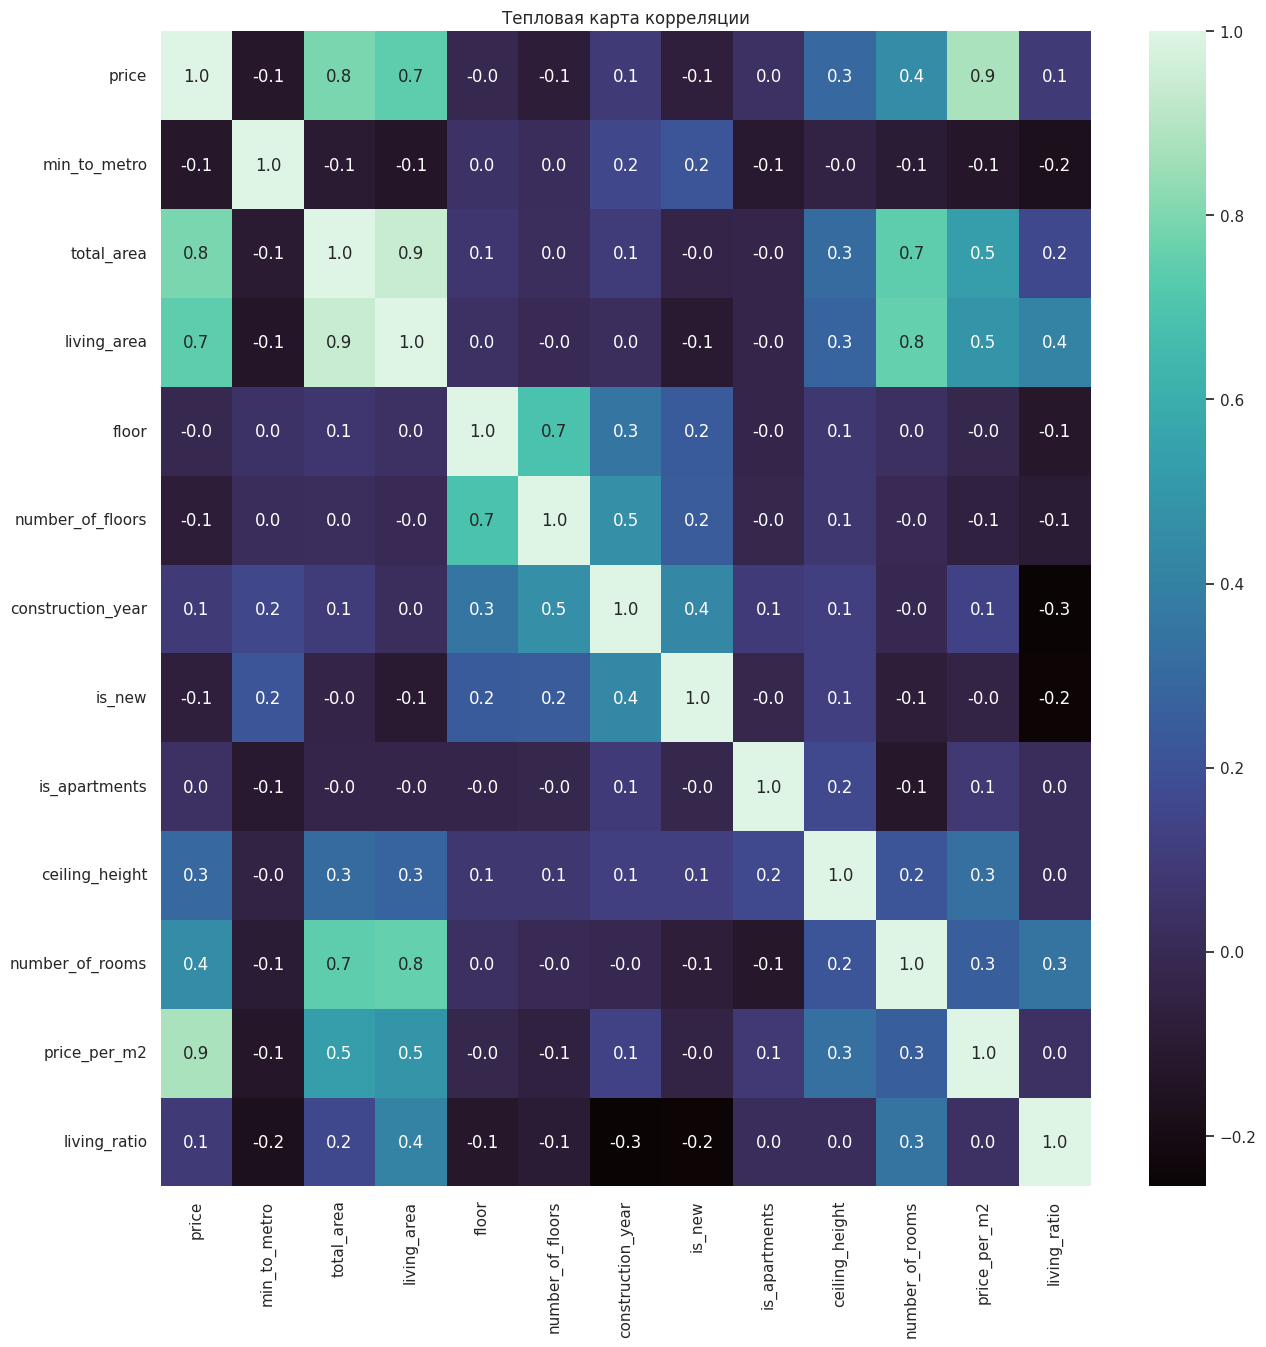

In [42]:
# Построю тепловую карту, коэффициенты корреляции окгруглю до 1 знака
plt.figure(figsize=(15,15))
sns.heatmap(final_df_group.corr(), annot=True, cmap='mako', fmt='.1f')
plt.title('Тепловая карта корреляции')
plt.show()

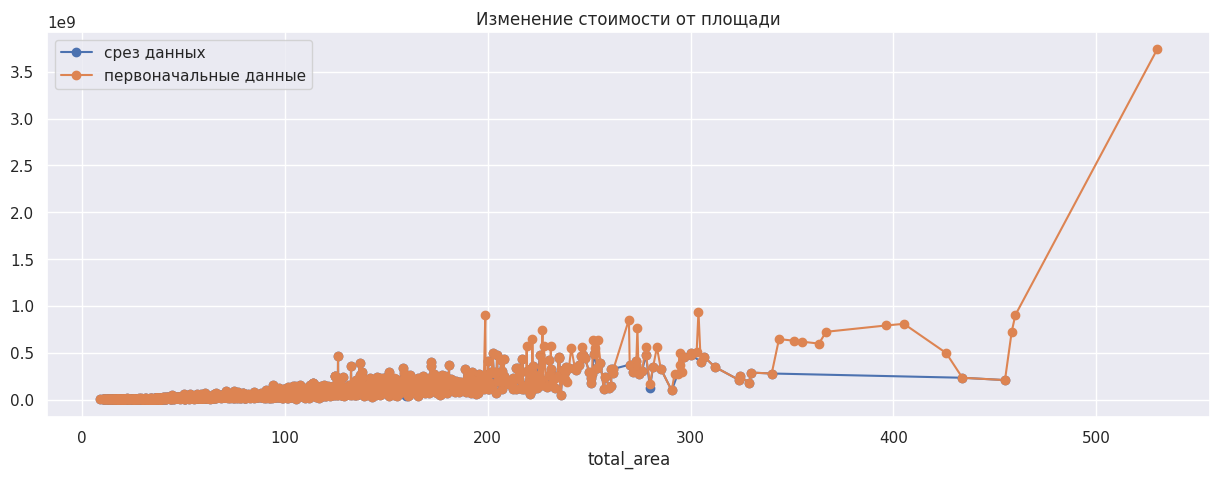

In [43]:
# Изучу зависимость стоимости от общей площади по общей таблице и срезу
final_df.groupby('total_area')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('total_area')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от площади')
plt.show()

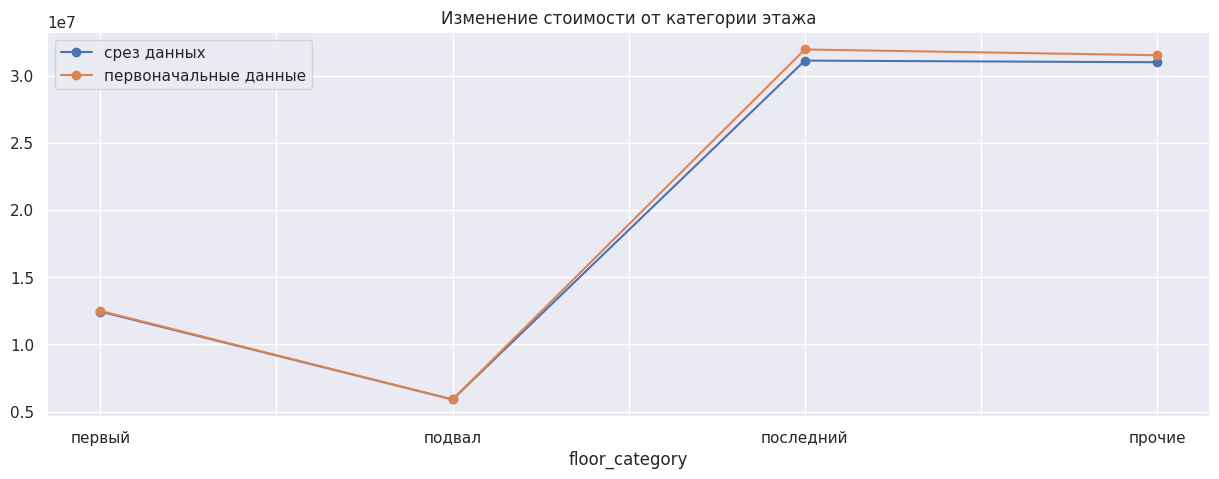

In [44]:
# Изучу зависимость стоимости от категории этажа
final_df.groupby('floor_category')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('floor_category')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от категории этажа')
plt.show()

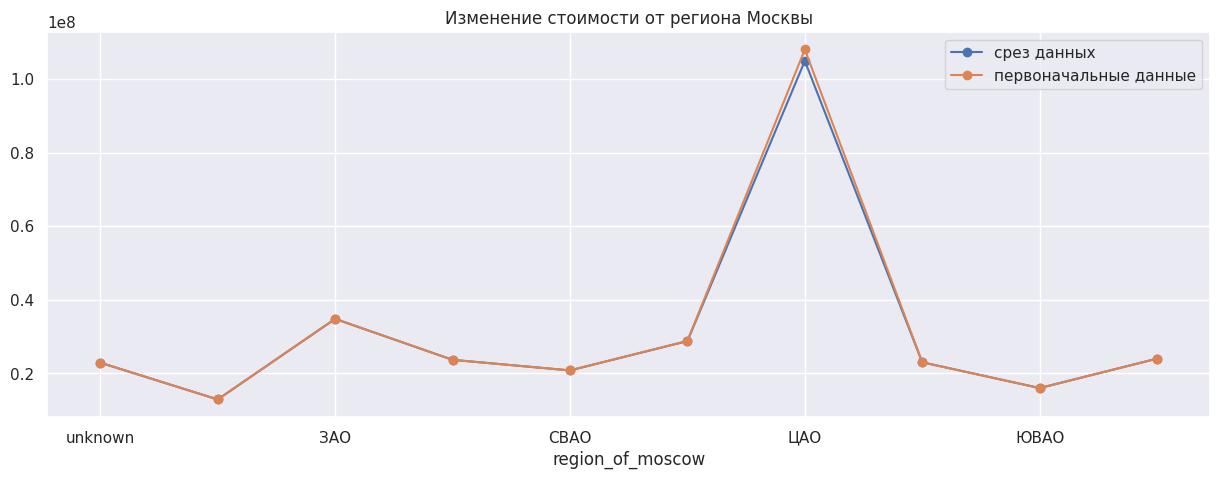

In [45]:
# Изучу зависимость стоимости от региона Москвы
final_df.groupby('region_of_moscow')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('region_of_moscow')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от региона Москвы')
plt.show()

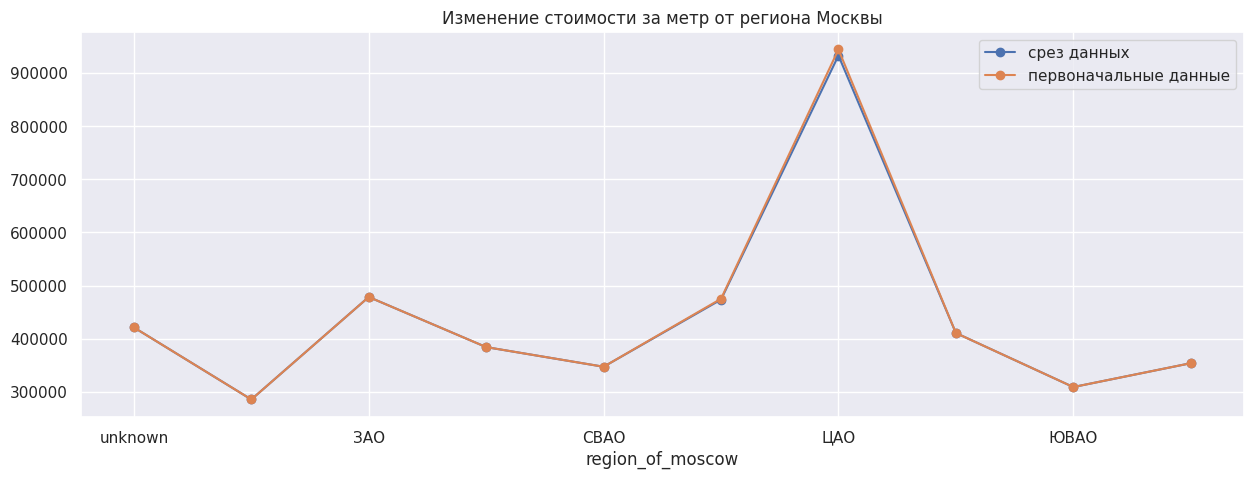

In [46]:
# Изучу зависимость стоимости за квадратный метр от региона Москвы
final_df.groupby('region_of_moscow')['price_per_m2'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('region_of_moscow')['price_per_m2'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости за метр от региона Москвы')
plt.show()

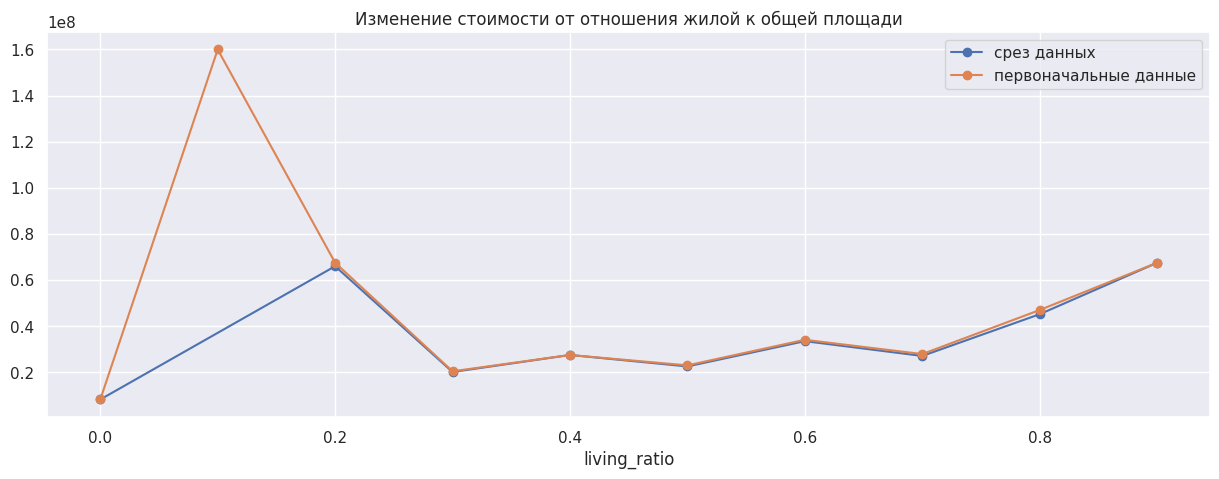

In [47]:
# Изучу зависимость стоимости от отношения жилой к общей площади
final_df.groupby('living_ratio')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('living_ratio')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от отношения жилой к общей площади')
plt.show()

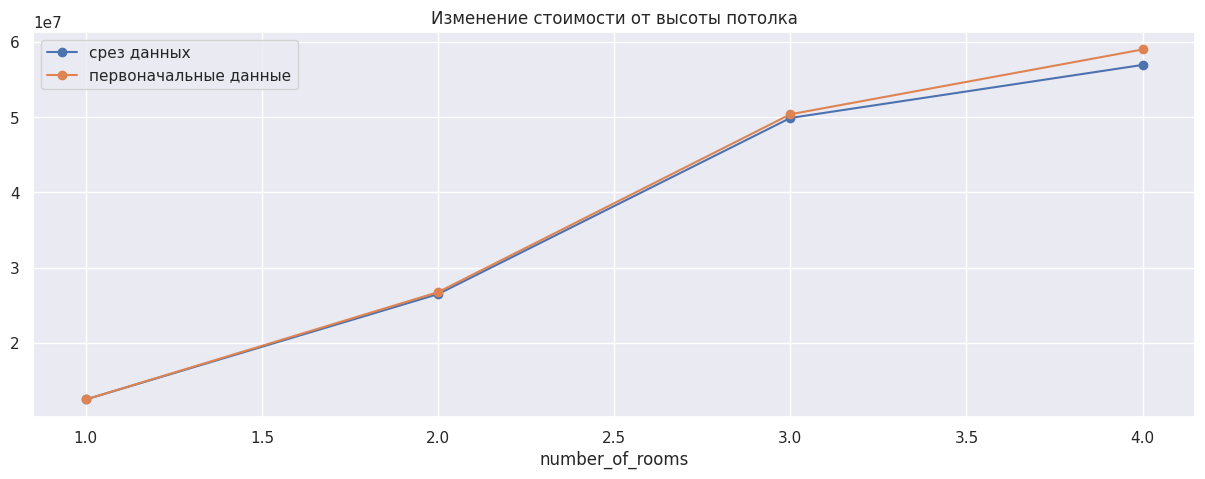

In [48]:
# Изучу зависимость стоимости от количества комнат
final_df.groupby('number_of_rooms')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)


df_cleaned.groupby('number_of_rooms')['price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от высоты потолка')
plt.show()

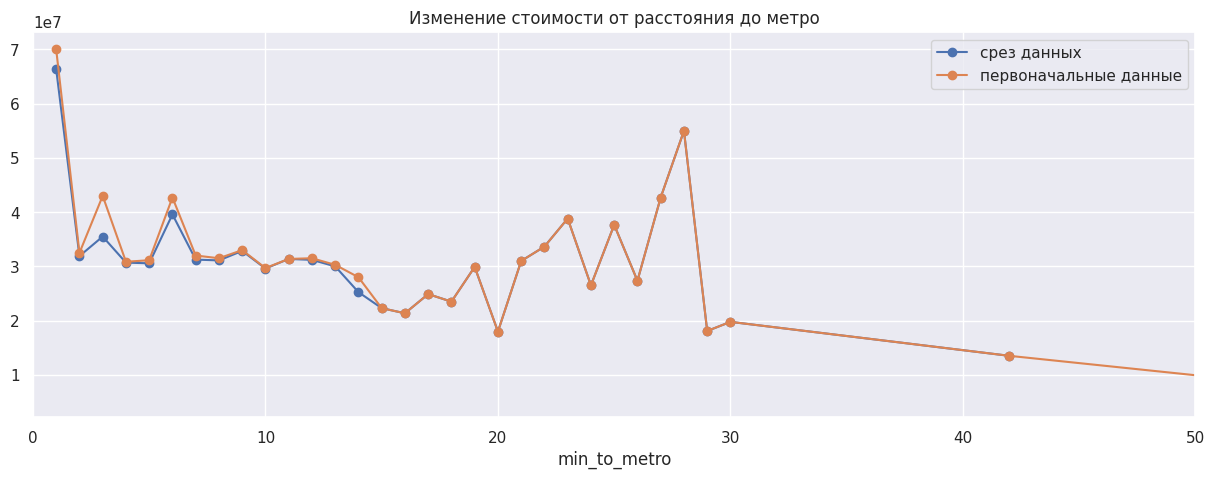

In [49]:
# Изучу зависимость стоимости от расстояния до метро
final_df.groupby('min_to_metro')['price'].agg('median').plot(
    x='year', style='o-', xlim=(0, 50), figsize=(15, 5), legend = True
)


df_cleaned.groupby('min_to_metro')['price'].agg('median').plot(
    x='year', style='o-', xlim=(0, 50), figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от расстояния до метро')
plt.show()

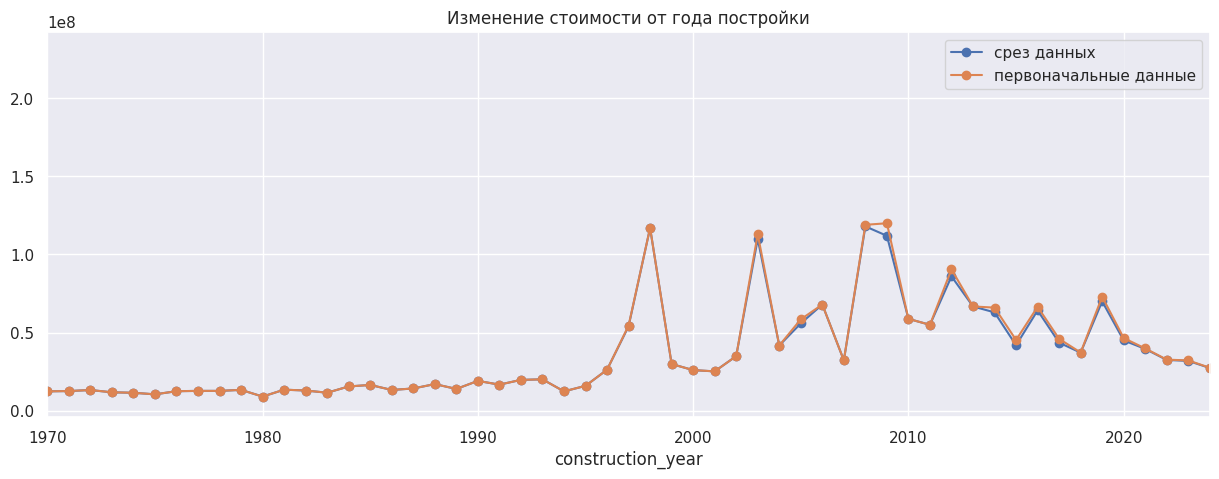

In [50]:
# Изучу зависимость стоимости от года постройки
final_df.groupby('construction_year')['price'].agg('median').plot(
    x='year', style='o-', xlim=(1970, 2024), figsize=(15, 5), legend = True
)


df_cleaned.groupby('construction_year')['price'].agg('median').plot(
    x='year', style='o-', xlim=(1970, 2024), figsize=(15, 5), legend = True
)

plt.legend(['срез данных', 'первоначальные данные'])
plt.title('Изменение стоимости от года постройки')
plt.show()

### Основной вывод

Исследование подтверждает доминирующую роль площадных характеристик в формировании цены московских квартир. Однако слабая линейная корреляция традиционных факторов (метро, этаж, год постройки) не означает их незначимости, а указывает на сложную, нелинейную природу их влияния, требующую применения более совершенных и углубленных методов анализа.

Главные факторы ценообразования (по данным исследования):
* 1. Цена за квадратный метр (r = 0,88) — интегральный показатель, учитывающий район, тип дома, состояние
* 2. Общая площадь (r = 0,79) — базовый физический параметр
* 3. Жилая площадь (r = 0,74) — уточняющий площадной параметр
* 4. Количество комнат (r = 0,45) — структурная характеристика планировки

Факторы с неожиданно слабым влиянием:
* Расстояние до метро (r = -0,13) — требует нелинейного моделирования
* Этаж (r = -0,02) — эффект нивелируется разнонаправленным влиянием
* Год постройки (r = 0,09) — нелинейная зависимость (сталинки vs хрущевки vs новостройки)

#### Ограничения текущего анализа
Линейная корреляция не улавливает: нелинейные зависимости (U-образные, пороговые эффекты), взаимодействия между переменными, категориальные эффекты.
Отсутствуют важные переменные: материал стен дома, состояние и качество отделки, наличие парковки, инфраструктура района.
Мультиколлинеарность: общая и жилая площадь высоко коррелируют (r = 0,94), что может искажать оценку индивидуального вклада в регрессии.

#### Ключевые инсайты по исследованию
1. Доминирование площадных характеристик — три из четырех наиболее сильных предикторов связаны с размером квартиры. Цена за м² (r = 0,88), общая площадь (r = 0,79), жилая площадь (r = 0,74), количество комнат (r = 0,45). Это указывает, что размер квартиры является критическим фактором, определяющим около 60-80% вариации цены (на основе R²).

2. Слабость локационных факторов в линейной модели — расстояние до метро показало неожиданно слабую корреляцию (-0,13), что не означает отсутствие влияния, а указывает на нелинейный характер зависимости. Возможное взаимодействие с ценой за м², необходимость категориальной, а не непрерывной переменной (0-5 мин / 5-10 мин / >10 мин).

3. Необходимость нелинейных моделей. Многие важные факторы (этаж, год постройки, расстояние до метро) имеют нелинейное влияние на цену, которое линейная корреляция не улавливает. При более глубоком исследовании оптимально было бы: применить полиномиальные признаки, использовать древесных модели (Random Forest, Gradient Boosting), создать категориальные переменные из непрерывных.

4. Установлены также скрытые взаимосвязи. Анализ матрицы корреляций выявил интересные паттерны:

* Living_ratio отрицательно коррелирует с годом постройки (r = -0,26): в старых домах доля жилой площади выше;
* Этаж и этажность дома сильно коррелируют (r = 0,69): логическая взаимосвязь;
* Is_new положительно связан с годом постройки (r = 0,43) и расстоянием до метро (r = 0,21): новостройки строятся дальше от центра.